In [11]:
import torch
import matplotlib.pyplot as plt
import os
import imageio
import datasets.toy_datasets as datasets
import utils.sde_lib as SDEs
from utils.model_utils import get_preconditioned_model
from utils.metrics import get_w2

torch.set_printoptions(precision=3,sci_mode=False)

In [12]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
is_sb = False
is_cld = True
sde_names = ['vp','cld']
dataset_name = 'unit-spiral' #board
model_paths = [f'./checkpoints/{dataset_name}-{sde}/itr_15000' for sde in sde_names]
sdes = [SDEs.VP(), SDEs.CLD()]
scores = [torch.load(os.path.join(model_path,'backward_ema.pt')) for model_path
                    in model_paths]
scores = [get_preconditioned_model(score, sde) for score, sde in zip(scores,sdes)]
for i,sde in enumerate(sdes):
    sde.backward_score = scores[i]

In [13]:
# SB 
model_path = f'./checkpoints/spiral-momentum-precond-var/itr_15000'
# model_path = f'./checkpoints/board-momentum/itr_11000'
forward_score = torch.load(os.path.join(model_path,'forward_ema.pt')) 
backward_score = torch.load(os.path.join(model_path,'backward_ema.pt'))
    
linear_momentum = SDEs.LinearMomentumSchrodingerBridge(forward_model=forward_score, backward_model=backward_score)

In [14]:
dataset = datasets.Spiral() if dataset_name == 'unit-spiral' else datasets.CheckerBoard()
true = dataset.sample(5000).to(device)
vp_samp, _ = sdes[0].sample((5000,2),device, n_time_pts=25)
cld_samp, _ = sdes[1].sample((5000,4),device, n_time_pts=25)
mom_samp, _ = linear_momentum.sample((5000,4),device, n_time_pts=25)
print(get_w2(true,vp_samp))
print(get_w2(true,cld_samp[:,:2]))
print(get_w2(true,mom_samp[:,:2]))

tensor(0.629, device='cuda:0')
tensor(0.627, device='cuda:0')
tensor(1.232, device='cuda:0')


In [15]:
def plot_trajectories(traj, save_path, gif_name='trajectories.gif'):
    idx = range(traj.shape[1])
    file_names = [os.path.join(save_path,f'{i}.png') for i in idx]
    dt = 1/(traj.shape[1]-1)
    plt.figure(figsize=(8, 8))  # Increase the figure size for better readability
    
    for i in idx:
        plt.clf()
        plt.title(f't = {dt * i : .2f}')
        plt.grid(zorder=0)
        plt.scatter(traj[:,i,0].detach().cpu(), traj[:,i,1].detach().cpu())
        plt.xlim(traj[:,-1:,0].cpu().min()-0.5, traj[:,-1:,0].cpu().max()+0.5)
        plt.ylim(traj[:,-1:,1].cpu().min()-0.5, traj[:,-1:,1].cpu().max()+0.5)

        plt.savefig(file_names[i])
    plt.clf()
    with imageio.get_writer(gif_name, mode='I', duration=0.05) as writer:
        for filename in file_names:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Optional: Clean up the temporary files
    # for filename in file_names:
    #     os.remove(filename)

def plot_lines(traj, filename):
    plt.clf()
    plt.figure(figsize=(8, 8))  # Increase the figure size for better readability

    # Add grid, labels, and title
    plt.grid(True, linestyle='--', linewidth=0.5)
    for i in range(traj.shape[0]):
        xi = traj[i]
        plt.plot(xi[:,0].cpu(), xi[:,1].cpu(), linewidth=1, alpha=.3)

    # plt.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(), label='start',zorder=1010, cmap='viridis', s=10, alpha=0.75)
    plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
    plt.xlim(traj[:,-1:,0].cpu().min()-0.5, traj[:,-1:,0].cpu().max()+0.5)
    plt.ylim(traj[:,-1:,1].cpu().min()-0.5, traj[:,-1:,1].cpu().max()+0.5)

    plt.legend()
    plt.savefig(filename,facecolor='none', edgecolor='none', transparent=True)

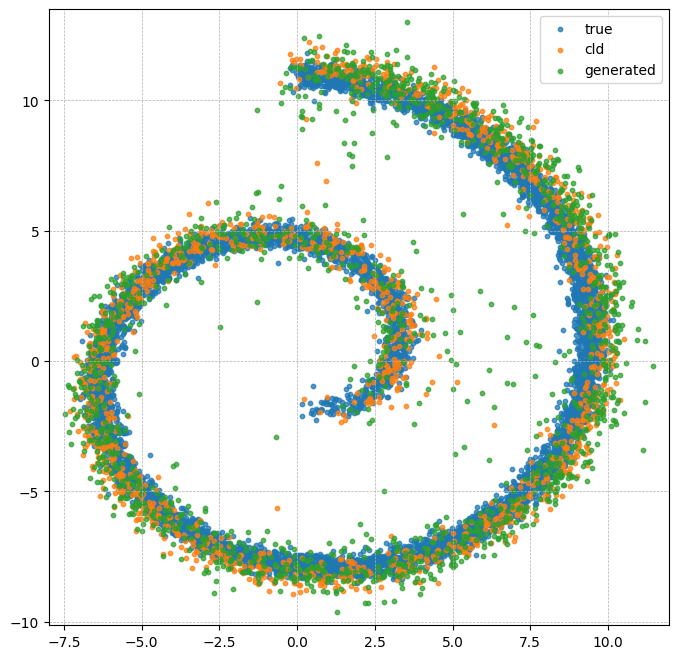

/tmp/ipykernel_566489/1627666375.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
/tmp/ipykernel_566489/1627666375.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<Figure size 640x480 with 0 Axes>

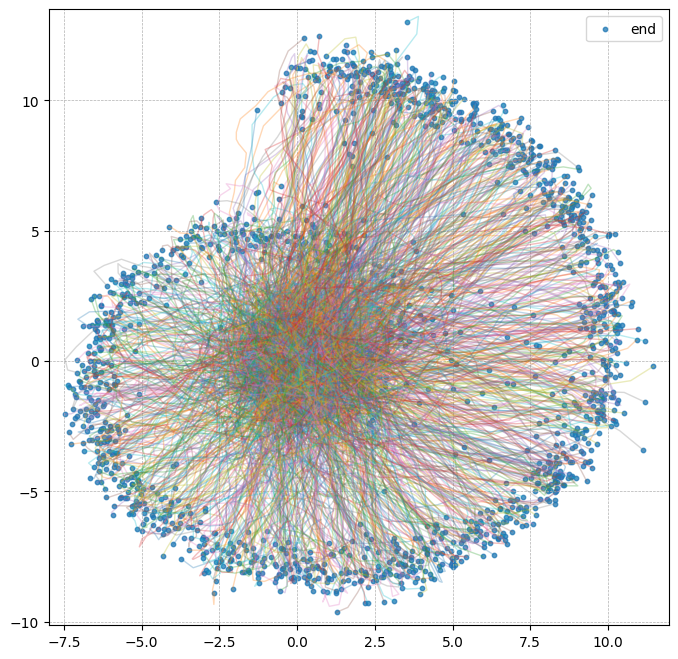

<Figure size 800x800 with 0 Axes>

In [20]:
n_samples = 1500
true_samples = dataset.sample(n_samples * 5)
samples, traj = linear_momentum.sample((n_samples,4),device,prob_flow=False,return_traj=True,n_time_pts=25)
cld_samp, traj_cld = sdes[1].sample((n_samples,4),device,prob_flow=False, return_traj=True, n_time_pts=25)
# Create the plot
plt.figure(figsize=(8, 8))  # Increase the figure size for better readability
plt.scatter(true_samples[:,0].cpu(), true_samples[:,1].cpu(), s=10, alpha=0.75,label='true')  # Use colormap, adjust size and transparency
plt.scatter(cld_samp[:,0].cpu(), cld_samp[:,1].cpu(), s=10, alpha=0.75, label='cld')  # Use colormap, adjust size and transparency
plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), s=10, alpha=0.75, label='generated')  # Use colormap, adjust size and transparency

# Add grid, labels, and title
plt.grid(True, linestyle='--', linewidth=0.5)

# Adjust the axis limits if needed
plt.xlim(samples[:,0].cpu().min()-0.5, samples[:,0].cpu().max()+0.5)
plt.ylim(samples[:,1].cpu().min()-0.5, samples[:,1].cpu().max()+0.5)
plt.legend()
# Show the plot
plt.show()

plot_lines(traj, f'trajectory/lines_momentum.png')
plot_trajectories(traj,save_path='./trajectory/momentum/',gif_name='trajectory/trajectories_board_momentum.gif')

/tmp/ipykernel_566489/1627666375.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_566489/1627666375.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)


<Figure size 800x800 with 0 Axes>

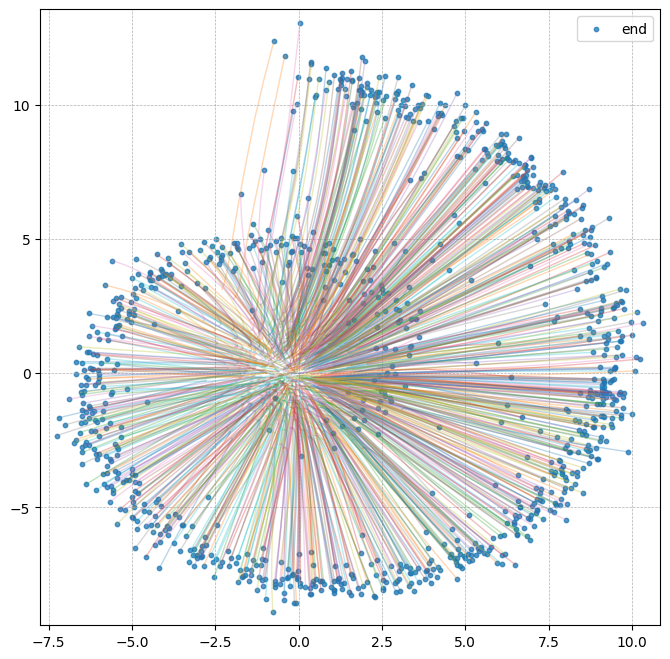

<Figure size 800x800 with 0 Axes>

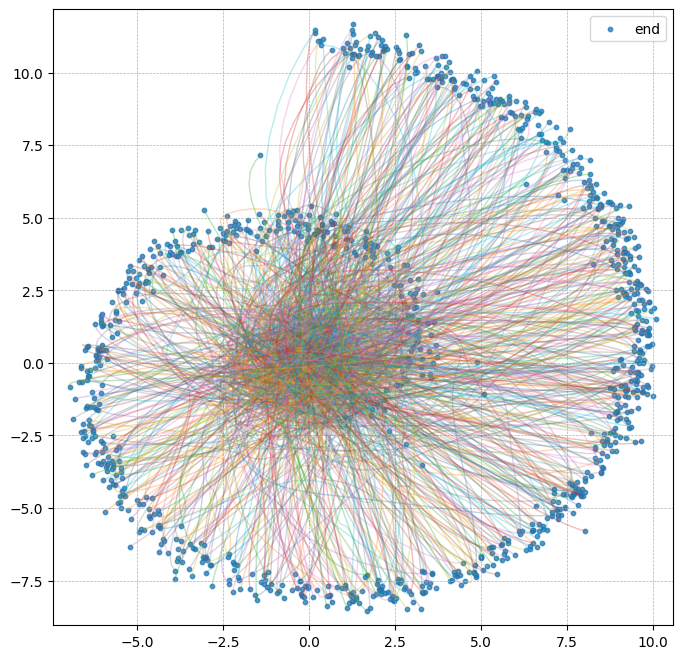

In [17]:
for sde_name, sde in zip(sde_names,sdes):
    n_samples = 1000
    in_cond = dataset.sample(n_samples).to(device=device)
    if isinstance(sde,SDEs.CLD):
        in_cond = torch.cat((in_cond,torch.randn_like(in_cond)),dim=1)
    shape = (n_samples,4 if isinstance(sde,SDEs.CLD) else 2)
    xt, traj = sde.sample(shape, device, backward=True,prob_flow=True, return_traj=True,n_time_pts=25,in_cond=in_cond)

    plot_trajectories(traj,save_path=f'./trajectory/{sde_name}/',gif_name=f'trajectory/trajectories_{dataset_name}_{sde_name}.gif')
    
    plot_lines(traj,f'trajectory/lines_{dataset_name}_{sde_name}.png')

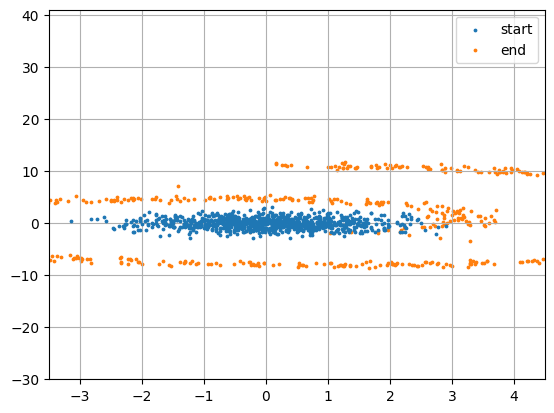

In [18]:
for sde_name, sde in zip(sde_names,sdes):
    plt.clf()
    plt.grid()
    plt.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(),s=3, label='start',zorder=1010)
    plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(), s=3,label='end')
    plt.xlim(-3.5,4.5)
    plt.ylim(-30,41)
    plt.legend()
    plt.savefig(f'trajectory/start_end_{sde_name}.png',facecolor='none', edgecolor='none', transparent=True)

In [19]:
n_pts = 20
x_pts = torch.linspace(-5,5,n_pts,device=device)#.view(-1,1)
y_pts = torch.linspace(-27,32,n_pts, device=device)#.view(-1,1)
x_pts, y_pts = torch.meshgrid((x_pts,y_pts))
x_pts = x_pts.reshape(-1,1)
y_pts = y_pts.reshape(-1,1)
z_pts = torch.cat((x_pts,y_pts),dim=-1)
n_time = 100
times = torch.linspace(0,1,n_time,device=device).unsqueeze(-1)
dt = 1/n_time
xt = dataset.sample(1000).to(device=device)
noise = torch.randn_like(xt)
for i,t in enumerate(times):
    t_shape = t.expand(z_pts.shape[0]).unsqueeze(-1)
    
    vector_field = sde.probability_flow_drift(z_pts,t_shape)
    plt.xlim(-27,32)
    plt.ylim(-27,32)
    plt.quiver(x_pts.cpu(),y_pts.cpu(),vector_field[:,0].cpu(),vector_field[:,1].cpu())
    plt.scatter(xt[:,0].cpu(), xt[:,1].cpu(),alpha=.3)
    plt.scatter(noise[:,0].cpu(), noise[:,1].cpu(),alpha=.1)
    plt.savefig(f'./vector-field/{i}.png')
    plt.clf()
    xt = xt + sde.probability_flow_drift(xt,t.expand(xt.shape[0]).unsqueeze(-1)) * dt


/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (400x3 and 5x128)